<a href="https://colab.research.google.com/github/ewakobrzynska/Biometria/blob/main/Rozpoznawanie_cech_II_poziomu_w_obrazach_odcisk%C3%B3w_palc%C3%B3w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rozpoznawanie cech II poziomu odcisków palców
Odciski palców są jednymi z najbardziej unikalnych biometrycznych cech tożsamościowych, wykorzystywanych powszechnie w systemach identyfikacji osób. Proces rozpoznawania odcisków palców składa się z kilku etapów, z których jeden obejmuje ekstrakcję cech drugiego poziomu, takich jak terminacje (końce) i bifurkacje (rozwidlenia) linii papilarnych.

Ten notatnik zawiera implementację algorytmów detekcji terminacji, bifurkacji oraz innych technik przetwarzania obrazów, które są wykorzystywane do ekstrakcji cech drugiego poziomu z odcisków palców.


#Import danych Kaggle

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'socofing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F38300%2F58521%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240702%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240702T085253Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ab7bf2fc5773d75b7004573cb3aacc8150e70c5f306ab4b81f61b305d6e46a0022d6dedeebd52db01e275739db3c450608943a7166536025cf69ef94460ed52d1d7cd006668ed5f0229232d8385ec073e61a13dc6a8ae93f9c8a3223e8159c80f67678717f3be467caf4a2059c118fc5b5fd8a43a8760582417d74abcac190c12536a4139fea117c69d7c67b3becdc9676f0ee4094efb923aee9eb79d9f68a5e9694e9efc3993a4c642a636d9f02d8fd5ee43979fab82e3f855e5f1a899620ad8381f64eb95136f1b939e29e3701cf530a8afd776d632328582aa457c60f06c93af6d56c36e68b7fd5be2b55bfbc9fad48b7678b8efed242b96771b2b7d9508'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 878317980 bytes downloaded
Downloaded and uncompressed: socofing
Data source import complete.


#Import bibliotek

Z rzadziej używanych na codzień bibliotek:

skimage: Jest to biblioteka do przetwarzania obrazów, która zawiera wiele algorytmów i narzędzi do analizy i manipulacji obrazami. Oferuje szereg funkcji do segmentacji, filtrowania, ekstrakcji cech itp.



In [ ]:
import numpy as np
import random
import imageio.v2 as imageio
import PIL, cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
import math
from skimage.morphology import convex_hull_image, erosion
import glob
from skimage.morphology import square



#Import bazy danych

Ten fragment kodu służy do wczytania listy ścieżek plików obrazów BMP znajdujących się w określonym katalogu.

In [ ]:
DATA_DIR = "../input/socofing/SOCOFing/Real/"
list_dirs = list(glob.glob(DATA_DIR+"*.BMP"))
num_images = len(list_dirs)
print("Number of images:", num_images)
print("List of directories:", list_dirs)


Number of images: 6000
List of directories: ['../input/socofing/SOCOFing/Real/230__M_Left_ring_finger.BMP', '../input/socofing/SOCOFing/Real/434__M_Right_index_finger.BMP', '../input/socofing/SOCOFing/Real/223__M_Left_thumb_finger.BMP', '../input/socofing/SOCOFing/Real/197__M_Left_little_finger.BMP', '../input/socofing/SOCOFing/Real/175__M_Left_thumb_finger.BMP', '../input/socofing/SOCOFing/Real/119__F_Right_index_finger.BMP', '../input/socofing/SOCOFing/Real/102__M_Right_middle_finger.BMP', '../input/socofing/SOCOFing/Real/66__F_Left_little_finger.BMP', '../input/socofing/SOCOFing/Real/421__F_Left_little_finger.BMP', '../input/socofing/SOCOFing/Real/538__M_Right_thumb_finger.BMP', '../input/socofing/SOCOFing/Real/18__M_Left_little_finger.BMP', '../input/socofing/SOCOFing/Real/492__F_Left_index_finger.BMP', '../input/socofing/SOCOFing/Real/189__F_Right_ring_finger.BMP', '../input/socofing/SOCOFing/Real/32__M_Right_index_finger.BMP', '../input/socofing/SOCOFing/Real/75__F_Right_middle_f

#Wyświetlenie przykładowych danych

Ten fragment kodu służy do losowego wyboru trzech obrazów z listy dostępnych obrazów i ich wyświetlenia w jednym wierszu za pomocą subwykresów Matplotlib.

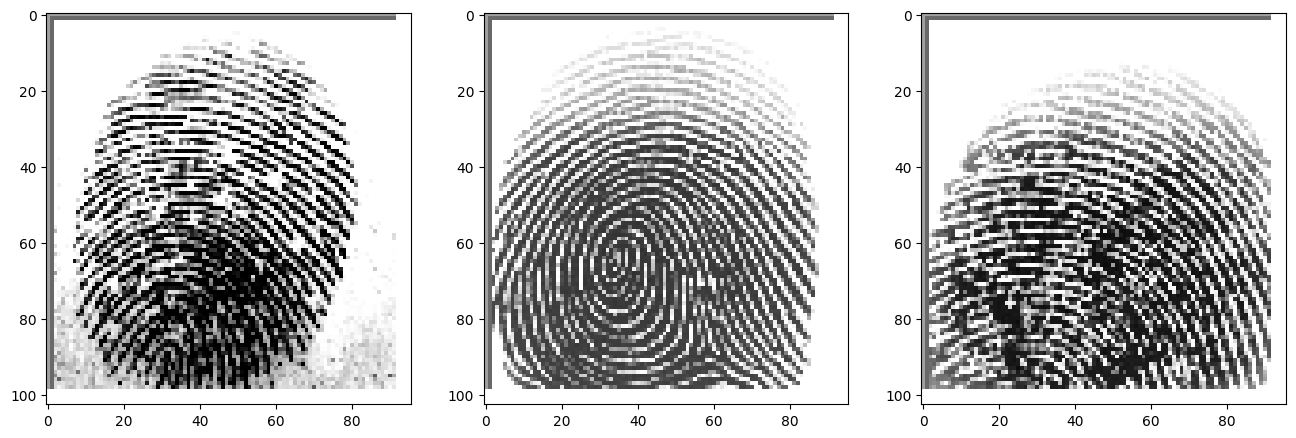

In [ ]:
# Ustawienie ziarna dla generatora liczb losowych
random.seed(42)

# Wylosowanie indeksu początkowego
start_index = random.randint(0, num_images)

# Wybranie trzech kolejnych obrazów
r = random.randint(0,num_images)
display_list = list_dirs[r:r+3]

image1 = imageio.imread(display_list[0])
image2 = imageio.imread(display_list[1])
image3 = imageio.imread(display_list[2])

images = [image1, image2, image3]

# Utworzenie wykresu z trzema obrazami
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
for ax, img in zip(axes, images):
    ax.imshow(img)
plt.show()


#Przekształcenia obrazu

W naszym algorytmie zastosowaliśmy różne transformacje obrazu, takie jak rozmycie Gaussa i medianowe rozmycie, aby zmniejszyć szumy i wygładzić obrazy, co ułatwia dalsze przetwarzanie.
Rozmycie obrazu za pomocą tych filtrów pomaga również usunąć drobne szczegóły, które mogą być nieistotne dla detekcji cech papilarnych.
Następnie przeprowadziliśmy analizę histogramów obrazów, aby zrozumieć ich charakterystykę, taką jak kontrast i rozkład intensywności pikseli, co pomogło nam w wyborze odpowiednich progów binaryzacji.

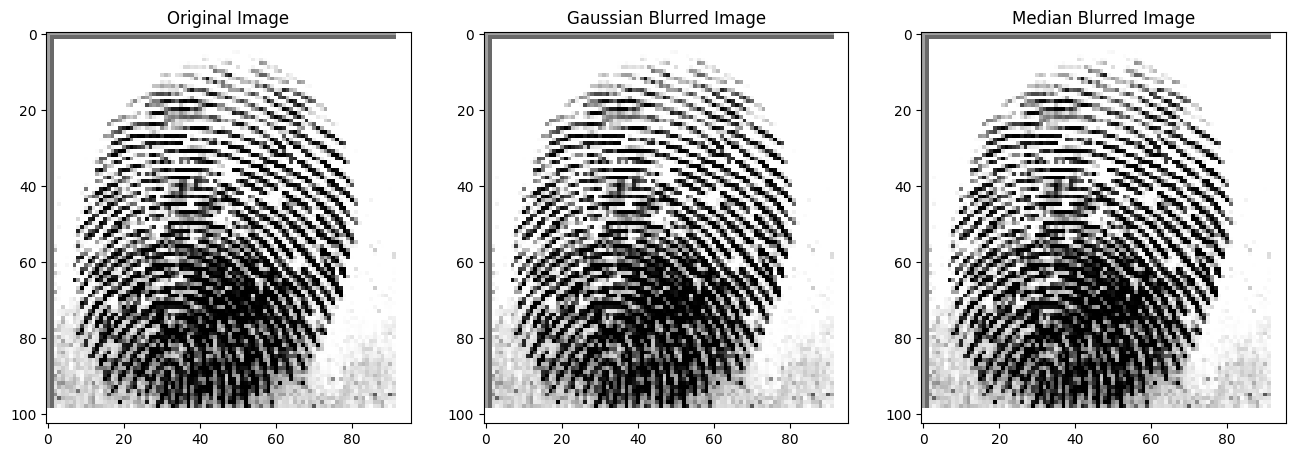

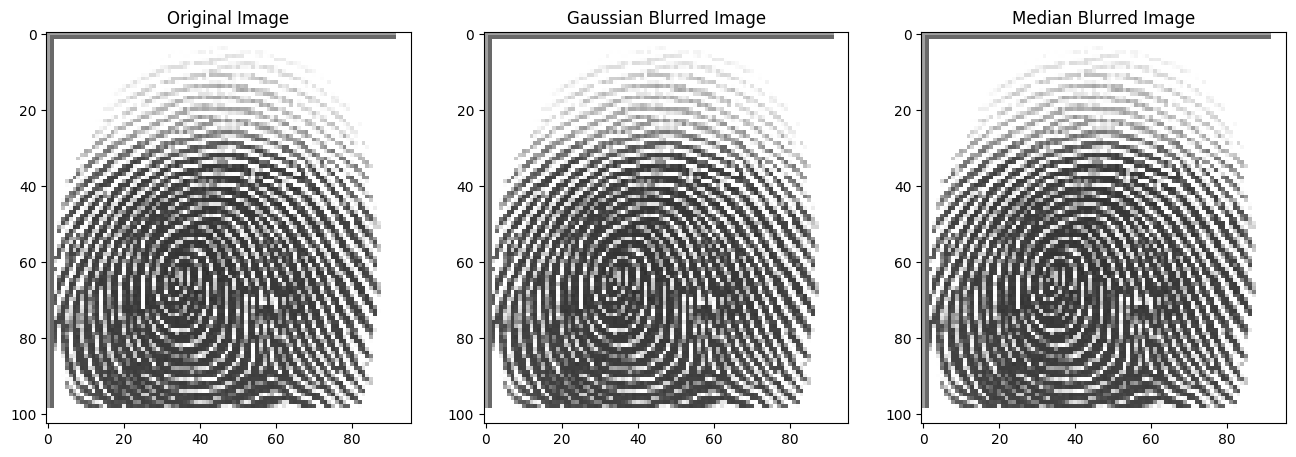

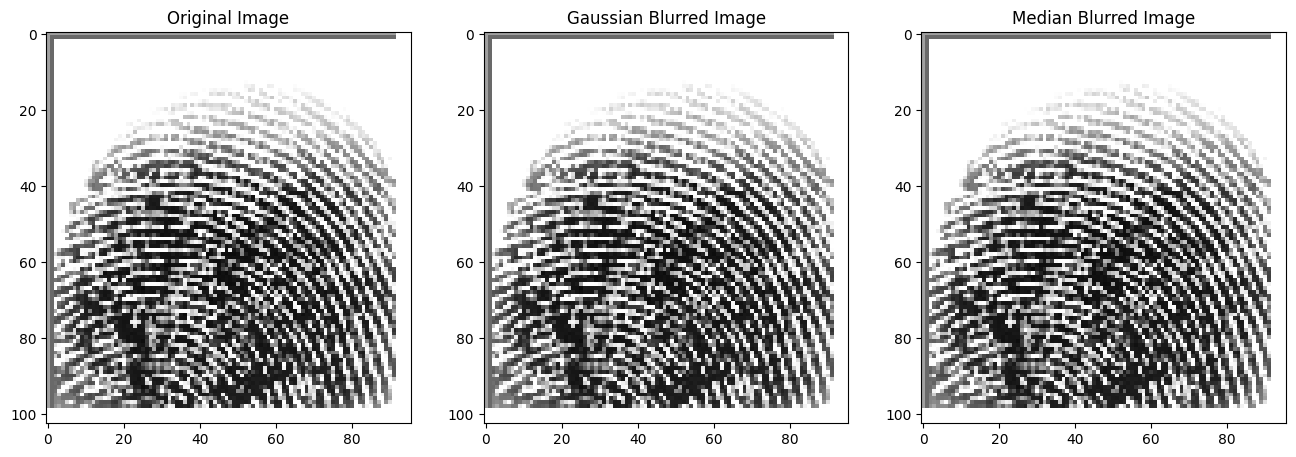

In [ ]:
def apply_and_display_blurs(image, ax):
    gauss_blur = cv2.GaussianBlur(image, (1, 1), 0)
    median_blur = cv2.medianBlur(image, 1)

    ax[0].set_title("Original Image")
    ax[0].imshow(image)
    ax[1].set_title("Gaussian Blurred Image")
    ax[1].imshow(gauss_blur)
    ax[2].set_title("Median Blurred Image")
    ax[2].imshow(median_blur)


for img in images:
    fig, axes = plt.subplots(1, 3, figsize=(16, 16))
    apply_and_display_blurs(img, axes)
    plt.show()


# Histogramy
Analiza histogramów była istotnym krokiem w naszym algorytmie, umożliwiającym wybór odpowiednich progów binaryzacji na podstawie charakterystyki intensywności pikseli na obrazach.
Pozwoliło nam to lepiej dostosować parametry binaryzacji do różnych obrazów, co jest kluczowe dla skuteczności detekcji cech papilarnych.

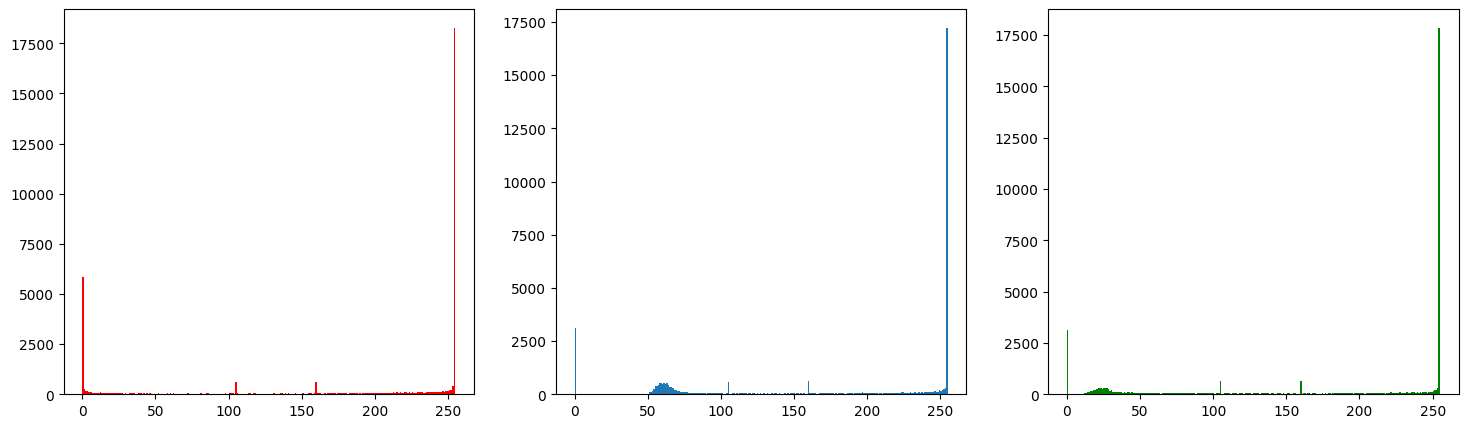

In [ ]:
fig, axes = plt.subplots(1,3,figsize = (18,5))
axes[0].hist(image1.ravel(), bins=256, color ="r");
axes[1].hist(image2.ravel(), bins=256);
axes[2].hist(image3.ravel(), bins=256, color ="g");

#Adaptacyjna binaryzacja
Zastosowaliśmy adaptacyjną binaryzację, aby lepiej oddzielić linie papilarne od tła w trudnych warunkach, takich jak zmienne oświetlenie.
Dzięki adaptacyjnej binaryzacji mogliśmy dostosować poziom progowania w różnych obszarach obrazu na podstawie ich lokalnego otoczenia, co przyczyniło się do dokładniejszej separacji cech papilarnych.

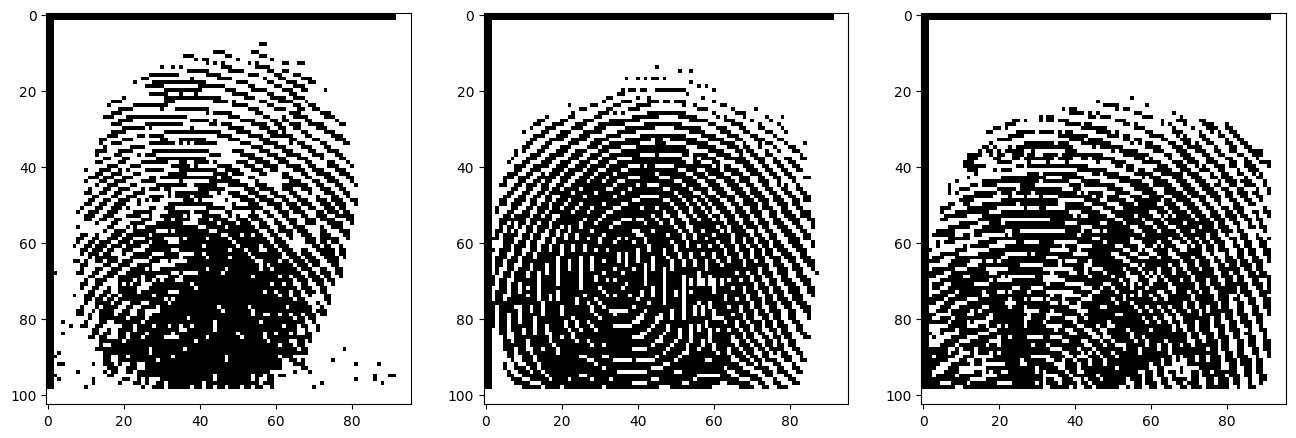

In [ ]:
def apply_threshold(image, threshold_value):
    return np.array(image > threshold_value).astype(int) * 255

images = [image1, image2, image3]
thresholds = [img.mean() for img in images]
processed_images = [apply_threshold(img, thr) for img, thr in zip(images, thresholds)]

fig, axes = plt.subplots(1, 3, figsize=(16, 16))
for ax, img in zip(axes, processed_images):
    ax.imshow(img)
plt.show()


#Progowanie adaptacyjne

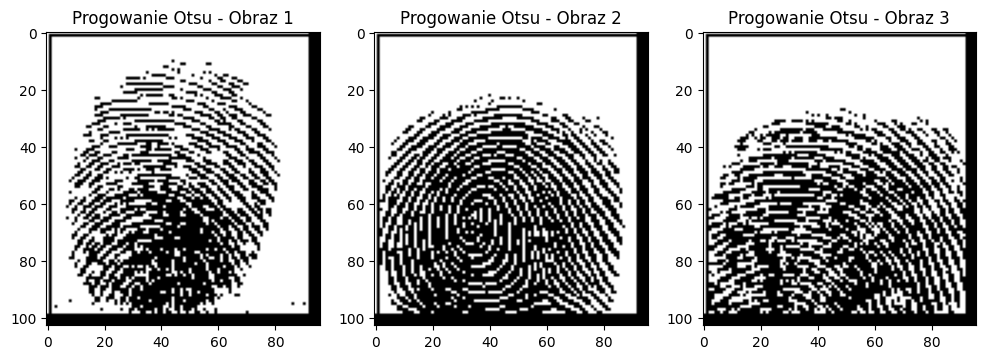

In [ ]:
def otsu_threshold(image_path):
    img = cv2.imread(image_path, 0)
    _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_img

# Ścieżki do obrazów
image_paths = display_list[:3]

# Zastosowanie progowania Otsu
thresholded_images = [otsu_threshold(path) for path in image_paths]

# Wyświetlanie obrazów
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
titles = ["Progowanie Otsu - Obraz 1", "Progowanie Otsu - Obraz 2", "Progowanie Otsu - Obraz 3"]

for ax, img, title in zip(axes, thresholded_images, titles):
    ax.set_title(title)
    ax.imshow(img, cmap='gray')

plt.show()


# Detekcja terminacji i bifurkacji

Ta funkcja służy do detekcji terminacji (końców) i bifurkacji (rozwidleń) na obrazie odcisku palca. Najpierw obraz odcisku palca jest przetwarzany poprzez binaryzację, co oznacza przypisanie wartości logicznej True dla pikseli białych (o wartości 255) i False dla pozostałych. Następnie algorytm przegląda piksele obrazu, pomijając piksele brzegowe, i dla każdego piksela tworzy blok 3x3. Suma wartości pikseli w tym bloku jest obliczana, a jeśli suma wynosi 2, oznacza to terminację, więc piksel ten jest zaznaczany jako terminacja w macierzy minutiaeTerm. Jeśli suma wynosi 4, oznacza to bifurkację, więc piksel ten jest zaznaczany jako bifurkacja w macierzy minutiaeBif. Na koniec wyniki detekcji są przycinane do obszaru określonego przez maskę, a następnie zwracane jako dwie macierze: minutiaeTerm zawierająca informacje o pozycjach terminacji oraz minutiaeBif zawierająca informacje o pozycjach bifurkacji. Dodatkowo, operacje przetwarzania obrazu, takie jak wygładzanie krawędzi za pomocą konwolucji, są stosowane w celu poprawy jakości wyników detekcji.


In [ ]:
def getTerminationBifurcation(img, mask):
    img = img == 255;
    (rows, cols) = img.shape;
    minutiaeTerm = np.zeros(img.shape);
    minutiaeBif = np.zeros(img.shape);

    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2,j-1:j+2];
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1;
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1;

    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

#Cechy II poziomu
Algorytm analizy odcisków palców wykorzystuje te cechy drugiego poziomu do budowy unikalnych profili odcisków palców, które można porównywać w celu identyfikacji osób. Proces ten obejmuje ekstrakcję, analizę i porównanie terminacji i bifurkacji ze zbiorami danych, aby ustalić tożsamość osoby na podstawie jej odcisków palców. Cechy te są istotne, ponieważ są unikalne dla każdej osoby i mają niski stopień zmienności w czasie, co sprawia, że są niezawodne w celach identyfikacyjnych.

In [ ]:
def extract_secondary_features(img, threshold):
    # Binaryzacja obrazu
    img_binary = np.array(img > threshold).astype(int)

    # Tworzenie szkieletu
    skel = skimage.morphology.skeletonize(img_binary)
    skel = np.uint8(skel) * 255

    # Uzyskanie maski
    mask = img_binary * 255

    # Wykrycie terminacji i bifurkacji
    minutiaeTerm, minutiaeBif = getTerminationBifurcation(skel, mask)

    # Ekstrakcja cech drugiego poziomu
    TermLabel = skimage.measure.label(minutiaeTerm, connectivity=1)
    BifLabel = skimage.measure.label(minutiaeBif, connectivity=1)

    # Zwrócenie cech drugiego poziomu
    return TermLabel, BifLabel


#Wyświetlanie rezultatów

In [ ]:
def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));

    plt.figure(figsize=(6,6))
    plt.title("Wyniki")
    plt.imshow(DispImg)

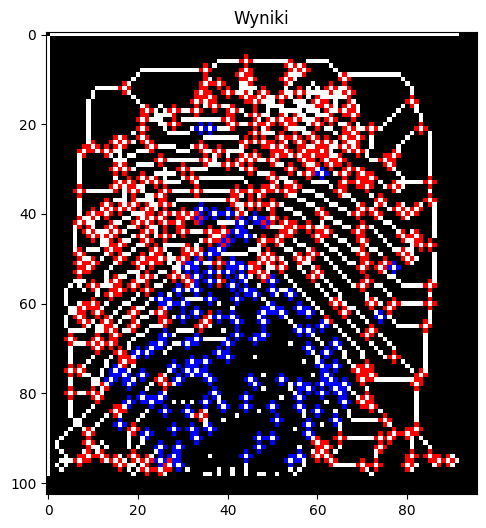

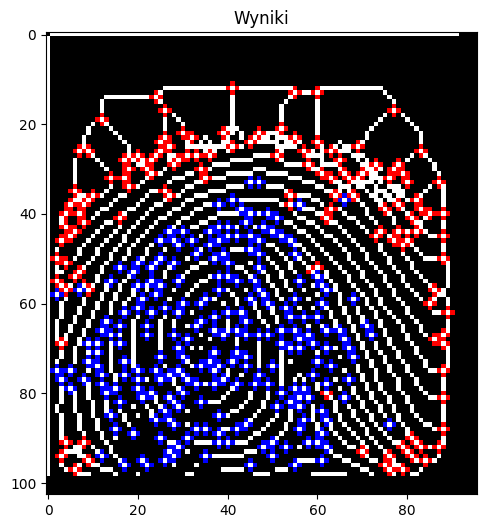

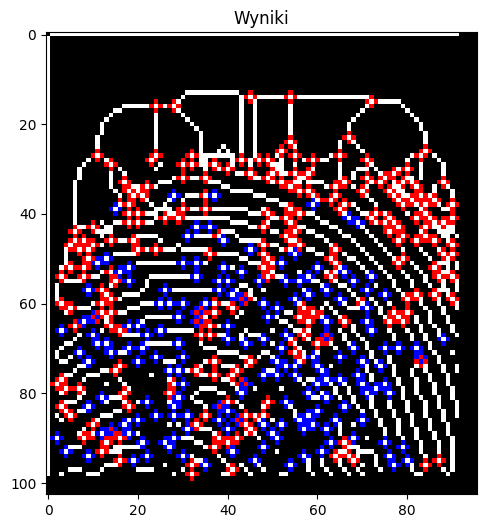

In [ ]:
for i in range (0,3):
  img_name = display_list[i]
  img = cv2.imread(img_name,0);
  THRESHOLD = img.mean() # lub dowolny inny próg
  img= np.array(img > THRESHOLD).astype(int)
  mask = img*255;
  skel = skimage.morphology.skeletonize(img)
  skel = np.uint8(skel)*255;
  (TermLabel, BifLabel) = extract_secondary_features(mask, THRESHOLD)

  # wywołanie funkcji ShowResults z odpowiednimi argumentami
  ShowResults(skel, TermLabel, BifLabel)